<a href="https://colab.research.google.com/github/R-A-N-N/Stackoverflow-Tag-Predictor/blob/main/SO_TagPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-multilearn

     |████████████████████████████████| 92kB 2.7MB/s 


##All import statements

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g49NrYbzjQu-Gx65Tckrc1FcpsBw76zOOIs--YsuFS8RDxRhlZPVjc
Mounted at /content/gdrive


## Loading the database

In [ ]:
con = sqlite3.connect('/content/gdrive/My Drive/so_train.db' , timeout=10)

In [ ]:
pd.read_sql_query('SELECT Title, Body, Tags FROM data', con)

,Title,Body,Tags
0,How can I can read and modify data from XML file?,<p>Please give me the simplest way to read or ...,c# .net xml exception-handling
1,Java 2Dimensional Boolean Array Values,<p>I'm having a problem with my 2 dimensional ...,java multidimensional-array boolean
2,O(1) algorithm to determine if node is descend...,<p>Imagine the following tree:</p>\n\n<pre><co...,algorithm tree trie descendant
3,C++ & DirectX - setting shader,<p>Does someone know a fast way to invoke shad...,c++ performance directx shader
4,How to convert QR code to number?,<p>i have created QR-code through this site <a...,android
...,...,...,...
406396,NetBeans: How to create a web service client t...,<p>I am trying to add a web service reference ...,java web-services ssl wsit
406397,Why does WPF require a STAThread attribute to ...,"<p>I am new to WPF, and in every tutorial I re...",wpf stathread
406398,"When i run aspnet_regsql, nothing is created i...",<p>When i run the aspnet_regsql.exe tool to ad...,.net sql-server-2005
406399,Prime Appearances in Fibonacci Number Factoriz...,"<p>Okay, THIS one is considerably more analyti...",number-theory prime-numbers fibonacci-numbers


In [ ]:
con2 = sqlite3.connect('/content/gdrive/My Drive/train_no_dup.db',timeout=10)

In [ ]:
con3 = sqlite3.connect('/content/train_no_dup1.db',timeout=10)

## Removing Null values

In [ ]:
pd.read_sql_query('Delete FROM data where Title IS NULL',con2)

In [ ]:
pd.read_sql_query('Delete FROM data where Tags IS NULL',con2)

In [ ]:
none = pd.read_sql_query("Select Title,Body,Tags FROM data WHERE Tags IS NULL",con2)
none

,Title,Body,Tags


##Counting the number of rows

In [ ]:
num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])

Number of rows in the database : 
 406401


##Checking for duplicates

In [ ]:
df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)

In [ ]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 9409 ( 2.31520099606054 % )


In [ ]:
pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags ORDER BY cnt_dup', con)

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss,1
3,-2) = (1,-\frac{3}{2},-1)$</p>,1
4,1),System.Globalization.CalendarWeekRule.FirstDay,System.DayOfWeek.Sunday);,1
...,...,...,...,...
396987,maven set classes time stamp before packing th...,<p>I want to set the time stamp of the classes...,maven,3
396988,optimality of 2 in a continued fraction theorem,<p>I'm giving some lectures on continued fract...,number-theory continued-fractions,3
396989,parse url and title from string of multiple hr...,<p>i need to parse the url and title from mult...,regex parsing coldfusion,3
396990,send value location continues after 10 minute,<p>i want to send my location into my database...,android database latitude longitude,3


In [ ]:
print(len(df_no_dup))

396981


In [ ]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    387650
2      9253
3        78
Name: cnt_dup, dtype: int64

## Counting number of tags in each set of question

In [ ]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")) if text else 0)
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup

Time taken to run this cell : 0:00:00.290083


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss,1,3
3,-2) = (1,-\frac{3}{2},-1)$</p>,1,2
4,1),System.Globalization.CalendarWeekRule.FirstDay,System.DayOfWeek.Sunday);,1,2
...,...,...,...,...,...
396987,“error: no such device” at boot in Ubuntu Serv...,<p>I have a configuration of 4 HDD's as Raid1 ...,server ubuntu-11.10 raid-1,1,3
396988,“git did not exit cleanly (exit code 128)” err...,<p>I am getting this error on my windows machi...,git tortoisegit git-bash,1,3
396989,“iTunes.app” incoming network connections?,<p>I am experiencing the same issue mentioned ...,itunes osx-lion,1,2
396990,“make & make install” software on Linux,<p>I have worked on Linux for a year. One thin...,linux make,1,2


In [ ]:
# distribution of number of tags per question
tag_count = df_no_dup.tag_count.value_counts()
tag_count

3     113343
2     105896
4      76244
1      54661
5      46837
17         2
11         2
10         2
19         1
16         1
14         1
8          1
6          1
Name: tag_count, dtype: int64

<BarContainer object of 13 artists>

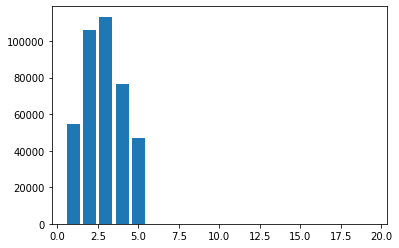

In [ ]:
plt.bar(tag_count.keys(),tag_count)

### As stackoverflow only allows maximum 5 tags per question, we need to delete the incorrect question data where number of tags > 5

In [ ]:
df_no_dup.drop(df_no_dup[df_no_dup['tag_count'] > 5].index, inplace = True)

In [ ]:
df_no_dup

,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss,1,3
3,-2) = (1,-\frac{3}{2},-1)$</p>,1,2
4,1),System.Globalization.CalendarWeekRule.FirstDay,System.DayOfWeek.Sunday);,1,2
...,...,...,...,...,...
396987,“error: no such device” at boot in Ubuntu Serv...,<p>I have a configuration of 4 HDD's as Raid1 ...,server ubuntu-11.10 raid-1,1,3
396988,“git did not exit cleanly (exit code 128)” err...,<p>I am getting this error on my windows machi...,git tortoisegit git-bash,1,3
396989,“iTunes.app” incoming network connections?,<p>I am experiencing the same issue mentioned ...,itunes osx-lion,1,2
396990,“make & make install” software on Linux,<p>I have worked on Linux for a year. One thin...,linux make,1,2


In [ ]:
tag_count = df_no_dup.tag_count.value_counts()
tag_count

3    113343
2    105896
4     76244
1     54661
5     46837
Name: tag_count, dtype: int64

In [ ]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup1.db'):
    disk_dup = create_engine("sqlite:///train_no_dup1.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('data',disk_dup)

## Analyzing tags

In [ ]:
pd.read_sql_query("Select * FROM no_dup_train",con3)

,index,Title,Body,Tags
0,0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c
1,1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding
2,2,java.lang.NoSuchMethodError: javax.servlet.S...,<p>i want to have a servlet to process inputs ...,java servlets jboss
3,3,-2) = (1,-\frac{3}{2},-1)$</p>
4,4,1),System.Globalization.CalendarWeekRule.FirstDay,System.DayOfWeek.Sunday);
...,...,...,...,...
396976,396987,“error: no such device” at boot in Ubuntu Serv...,<p>I have a configuration of 4 HDD's as Raid1 ...,server ubuntu-11.10 raid-1
396977,396988,“git did not exit cleanly (exit code 128)” err...,<p>I am getting this error on my windows machi...,git tortoisegit git-bash
396978,396989,“iTunes.app” incoming network connections?,<p>I am experiencing the same issue mentioned ...,itunes osx-lion
396979,396990,“make & make install” software on Linux,<p>I have worked on Linux for a year. One thin...,linux make


In [ ]:
start = datetime.now()
tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con3)
#Always remember to close the database
# Let's now drop unwanted column.
tag_data.drop(tag_data.index[0], inplace=True)
#Printing first 5 columns from our data frame
tag_data


,Tags
1,c# silverlight data-binding
2,java servlets jboss
3,-1)$</p>
4,System.DayOfWeek.Sunday);
5,0)$
...,...
396976,server ubuntu-11.10 raid-1
396977,git tortoisegit git-bash
396978,itunes osx-lion
396979,linux make


### Counting number of unique tags

In [ ]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])


In [ ]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 396980
Number of unique tags : 28933


Out of all 396983 entries, there are total 28986 unique tags

In [ ]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:20])

Some of the tags we have : ['-1)$</p>', '.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.each', '.emf', '.exe', '.htaccess', '.htpasswd', '.ico', '.lib', '.net', '.net-1.0', '.net-1.1', '.net-2.0', '.net-3.0']


## Number of times a tag appeared

In [ ]:
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

### Dictionary containing tag name and count pair


In [ ]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df

,Tags,Counts
0,.a,1
1,.app,3
2,.aspxauth,2
3,.bash-profile,10
4,.class-file,4
...,...,...
28981,zxing,56
28982,zypper,1
28983,zywall,1
28984,zyxel,3


In [ ]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values
tag_counts

array([30554, 27166, 26019, ...,     1,     1,     1])

In [ ]:
tag_df_sorted

,Tags,Counts
3071,c#,30554
12561,java,27166
18762,php,26019
12629,javascript,24292
875,android,21218
...,...,...
15431,mixed-authentication,1
15432,mixed-code,1
15435,mixin,1
15440,mjsip,1


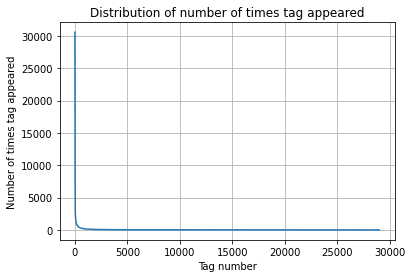

In [ ]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

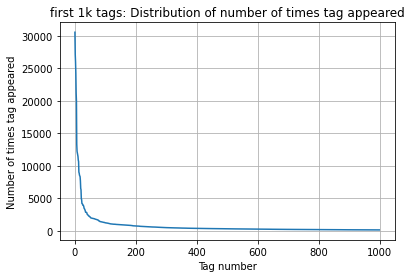

In [ ]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

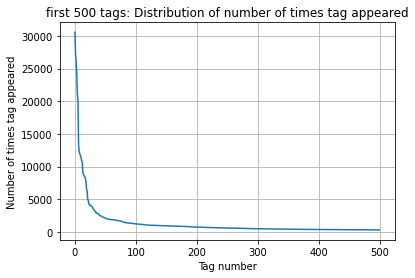

In [ ]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

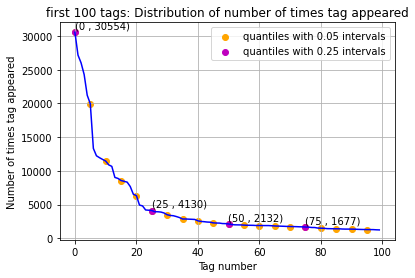

In [ ]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [ ]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>1000].Tags
#Print the length of the list
print ('{} Tags are used more than 1000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list.
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_100k)))

136 Tags are used more than 1000 times
13 Tags are used more than 10000 times


## Observations:
1) There are total 136 tags which are used more than 1000 times.

2) 13 tags are used more than 10000 times.

3) Most frequent tag (i.e. c#) is used 30554 times.

4) Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

## Tags per question

In [ ]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 396980 datapoints.
[3, 3, 1, 1, 1]


In [ ]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.885881


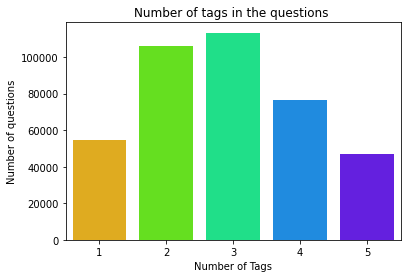

In [ ]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

##Observations:

1)Maximum number of tags per question: 5

2)Minimum number of tags per question: 1

3)Avg. number of tags per question: 2.885

4)Most of the questions are having 3 or 2 tags

## Most frequent tags

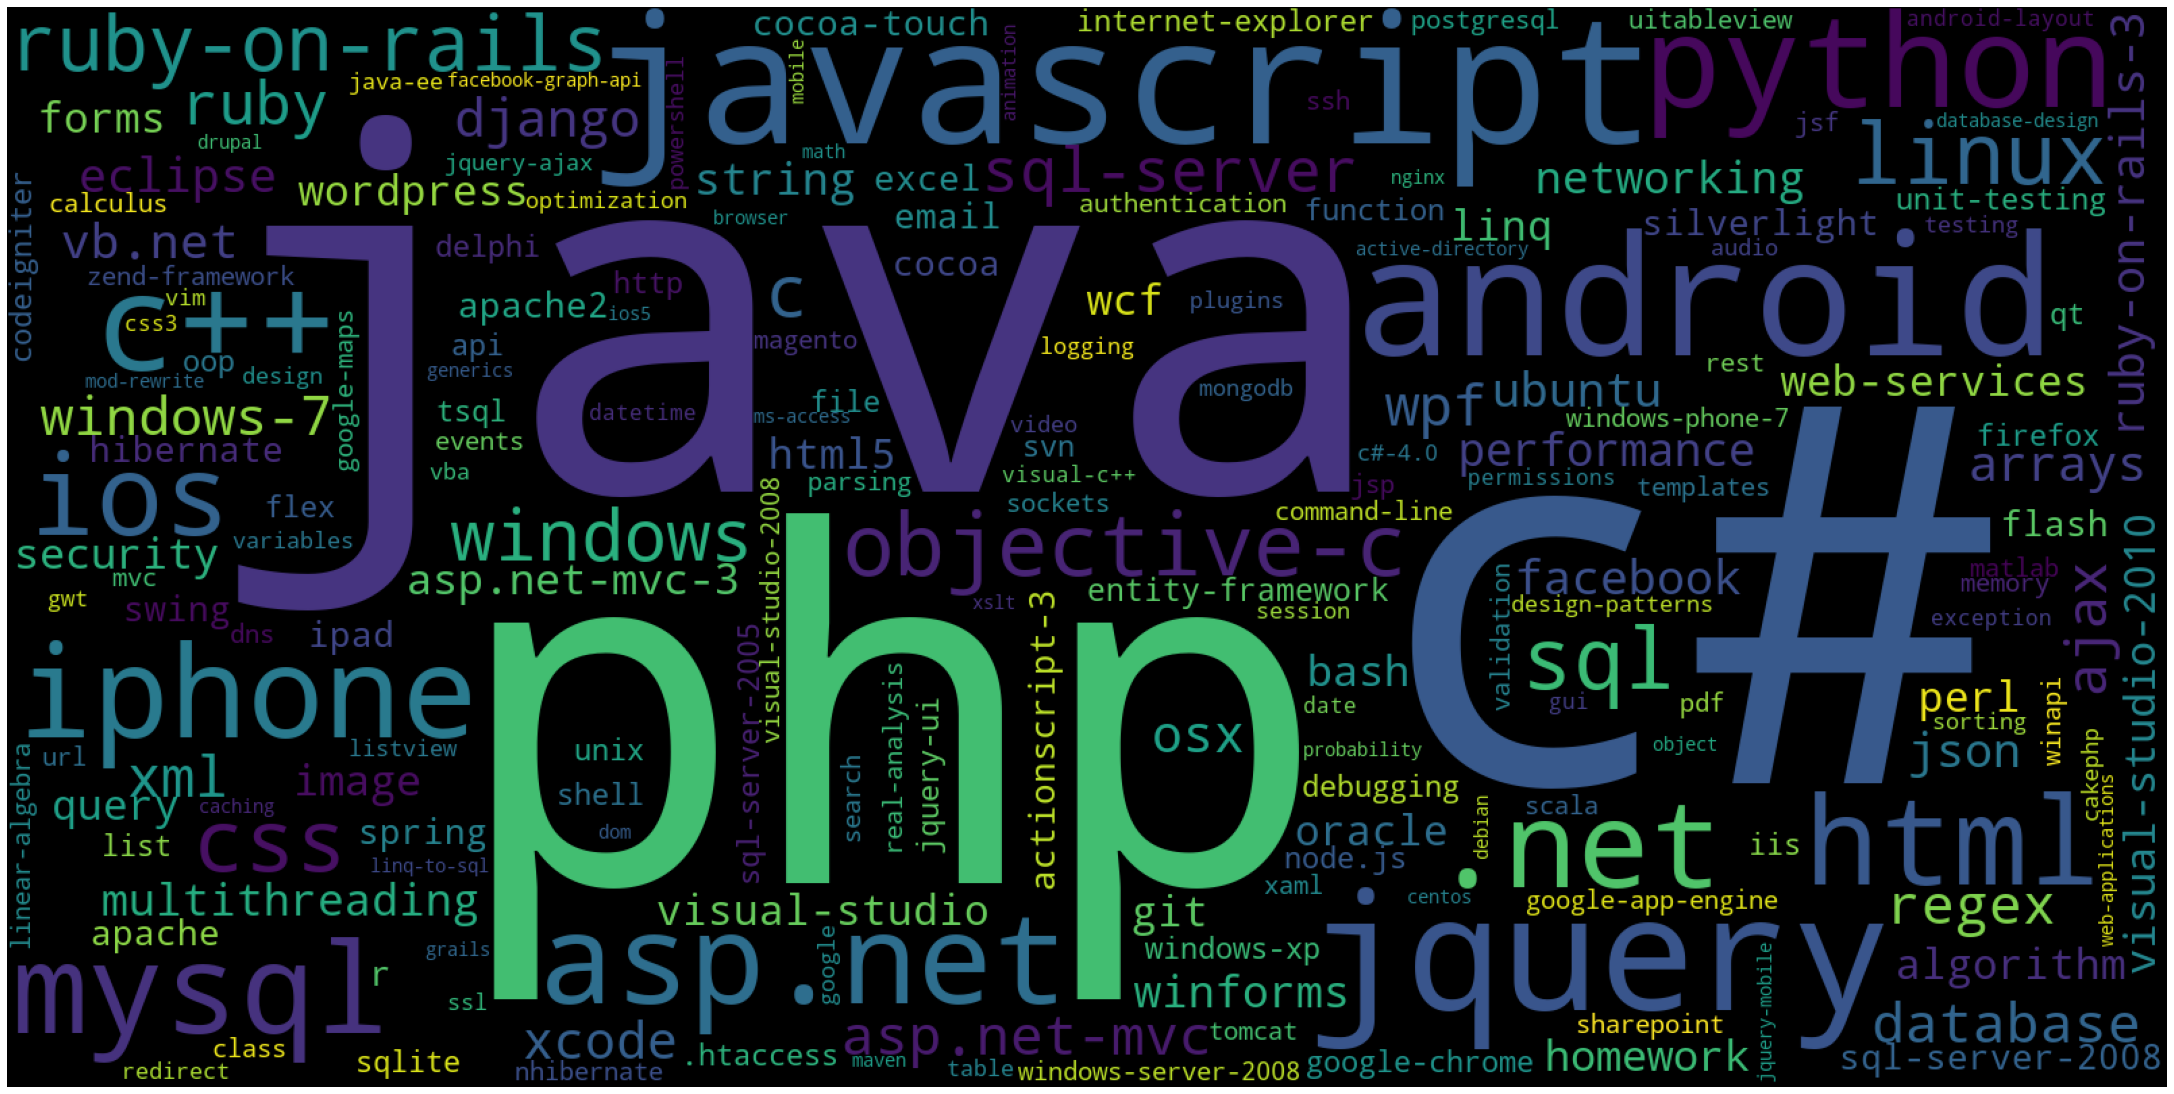

In [ ]:
# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

##Observations:
A look at the word cloud shows that "c#", "java", "php", "java", "javascript", "android" are some of the most frequent tags.

###Top 20 tags

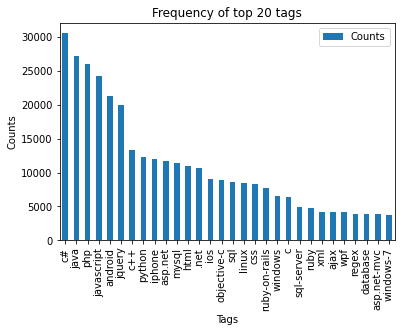

In [ ]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

##Observations:

Majority of the most frequent tags are programming language.
C# is the top most frequent programming language.
Android, IOS, Linux and windows are among the top most frequent operating systems.

In [ ]:
con.commit()
con2.commit()
con3.commit()
con.close()
con2.close()
con3.close()

## Preprocessing 


1.   Sample 1M data points
2.   Separate out code-snippets from Body
3.   Remove Spcial characters from Question title and description
4.   Remove stop words (Except 'C')
5.   Remove HTML Tags
6.   Convert all the characters into small letters
7.   Use SnowballStemmer to stem the words



In [ ]:
from nltk.corpus import stopwords
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [ ]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn4 = sqlite3.connect(db_file, timeout=10)
        return conn4
    except Error as e:
        print(e)
 
    return None

def create_table(conn4, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn4.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    database1 = '/content/'+database
    conn4 = create_connection(database1)
    if conn4 is not None:
        create_table(conn4, query)
        checkTableExists(conn4)
    else:
        print("Error! cannot create the database connection.")
    conn4.close()



In [ ]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [ ]:
start = datetime.now()
read_db = 'train_no_dup1.db'
write_db = 'Processed.db'
if os.path.isfile('read.db'):
    conn_r = create_connection('content/read_db')
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile('write_db'):
    conn_w = create_connection('content/write_db')
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)


# #Creating a new database with no duplicates
# if not os.path.isfile('train_no_dup1.db'):
#     disk_dup = create_engine("sqlite:///train_no_dup1.db")
#     no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
#     no_dup.to_sql('data',disk_dup)


Time taken to run this cell : 0:00:00.000437


PunktTrainer directly allows for incremental training and modification of the hyper-parameters used to decide what is considered an abbreviation, etc.

In [ ]:
nltk.download('punkt') 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True


we create a new data base to store the sampled and preprocessed questions

In [ ]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0


for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)


no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
Avg. length of questions(Title+Body) before processing: 1152
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 56
Time taken to run this cell : 0:09:24.128418


In [ ]:
# dont forget to close the connections, or else the database will be locked 
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

ProgrammingError: ignored

In [ ]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed


In [ ]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()
preprocessed_data.head()

,question,tags


In [ ]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 0
number of dimensions : 2
